In [21]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import ocr_methods as ocr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from timeit import default_timer as timer

### Definição do Ponto Inicial

In [22]:
#exterior
x = np.array([5., 5.])

#interior
#x = np.array([-0.5, -0.5])

### Plot - Definição das curvas de nível e do range dos eixos

In [23]:
x1range = np.linspace(-(x[0]+1), x[0] + 1)
x2range = np.linspace(-(x[1]+1), x[1] + 1)
levellist = [ 0, 50, 200, 400, 800, 1600]
#levellist = 6


### Escolha dos métodos de OSR e OCR

In [24]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 1

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 1

if (metodo_osr == 1):
        n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [25]:
# numero maximo de iteracoes na OSR
maxiter = 200

# tolerancia para convergencia do gradiente na OSR
tol_conv = 1E-5

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-6

# delta alpha do passo constante na OSR
line_step = 1E-2

#epsilon da maquina
eps = 1E-8

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 1
    beta = 0.1

#tolerancia OCR
tol = 1E-2

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [26]:
def f(x):
    return -((x[0]+1)**2 + (x[1]+1)**2)

def grad_f(x):
    return np.array([-2*(x[0]+1), -2*(x[1]+1)])

def hess_f(x):
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([-2.,0.])
    hess[1,:] = np.array([0.,-2.])
    return hess

### Definição das restrições de desigualdade

In [27]:
def cl1(x):
    return x[0]**2 + x[1]**2 - 2

def grad_cl1(x):
    return np.array([2*x[0],2*x[1]])

def hess_cl1(x):
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([2.,0.])
    hess[1,:] = np.array([0.,2.])
    return hess

### Listas de Restrições e suas derivadas

In [28]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1]
grad_cl_list = [grad_cl1]
hess_cl_list = [hess_cl1]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

Univariante
1: x=[1.36602243 1.36602887], r=1, passos=69
2: x=[1.04765671 1.04778564], r=10, passos=200
3: x=[0.98843128 1.02117391], r=100, passos=200
4: x=[0.98140475 1.01922802], r=1000, passos=200


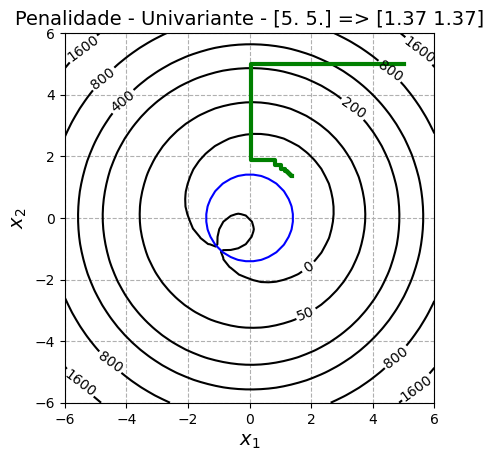

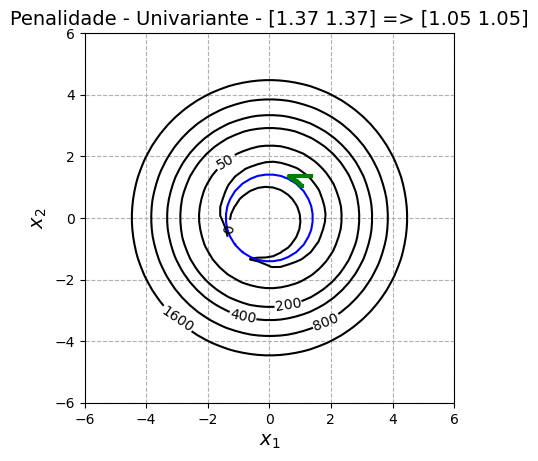

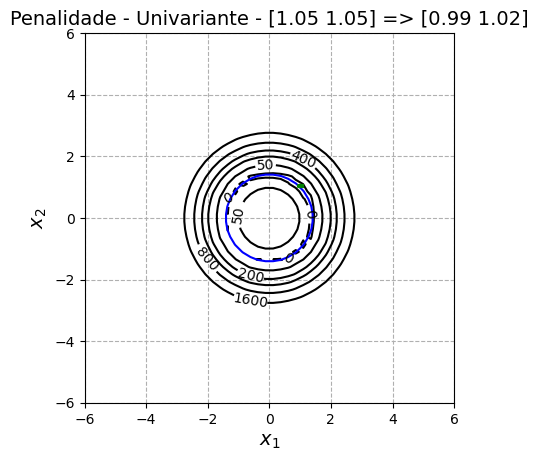

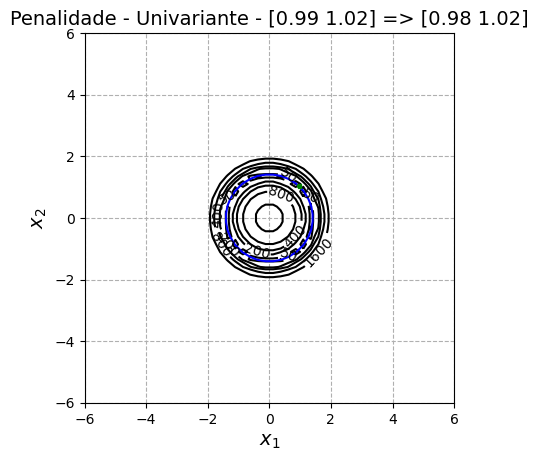

In [29]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listFigs = []

passos_OCR = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 1:
        r = beta*r
        if metodo_ocr == 1:
            cl_mont = []
            for cl in cl_list:
                if cl(x) > 0:
                    cl_mont.append(1)
                else:
                    cl_mont.append(0)
    listP_OSR, passos_OSR, flag_conv_OSR, tempoExec_OSR, fig = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr, x1range, x2range, levellist)
    x = listP_OSR[-1]
    listP_OCR.append(x)
    listFigs.append(fig)
    if metodo_ocr == 1:
        parc = (1/2)*r*ocr.p_penal(x, params)
    elif metodo_ocr == 2:
        parc = r*ocr.b_bar(x, params)
    print(f'{passos_OCR}: x={x}, r={r}, passos={passos_OSR}')
    #plt.close()
    

### Plots

In [30]:
# fig = plt.figure()
# frames=[]
# for i in np.arange(len(listFigs)):
#     frames.append([plt.imshow(listFigs[i], cmap=cm.Greys_r,animated=True)])
# ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,repeat_delay=1000)
# plt.show()